In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import datamol as dm
import vae_cyc as vc
import pandas as pd 
import pytorch_lightning as pl 
import wandb
import numpy as np
from torch.utils.data import DataLoader 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [163]:
# from datasets import load_dataset

# ds = load_dataset("sagawa/pubchem-10m-canonicalized")

In [164]:
# df = ds['train'].to_pandas().sample(n=100000)

In [167]:
df = pd.read_csv('/workspace/moses.csv')
df = df.sample(n=1000000)
df = df.reset_index()


In [168]:
vocab = vc.Vocab(df, 'SMILES')
df['str_len'] = df.SMILES.str.len()

extracting charset..



100%|██████████| 1000000/1000000 [00:02<00:00, 389608.63it/s][A


In [169]:
vocab.char2idx

{'<sos>': 0,
 '<eos>': 1,
 '<pad>': 2,
 '<unk>': 3,
 'C': 4,
 'N': 5,
 'c': 6,
 '1': 7,
 'n': 8,
 'S': 9,
 '(': 10,
 '=': 11,
 'O': 12,
 ')': 13,
 '2': 14,
 '3': 15,
 's': 16,
 'o': 17,
 '-': 18,
 'Q': 19,
 'F': 20,
 '#': 21,
 'X': 22,
 'W': 23,
 '4': 24,
 '5': 25,
 'Y': 26,
 '6': 27}

In [170]:
train_df, val_df = train_test_split(df, test_size=0.1)

train_dataset = vc.TransformerSMILESDataset(train_df.SMILES.values, vocab, 128 , pretokenize=True)

val_dataset = vc.TransformerSMILESDataset(val_df.SMILES.values, vocab, 128, pretokenize=True)

checkpoint_callback = ModelCheckpoint(dirpath='/workspace/pubchem-vae-large/', verbose=True, save_top_k=3,monitor='train_loss',save_last=True)


100%|██████████| 900000/900000 [00:05<00:00, 174186.92it/s]

100%|██████████| 100000/100000 [00:00<00:00, 287192.18it/s][A


In [171]:
train_dataset.max_len

128

In [172]:
train_dl = DataLoader(train_dataset,batch_size=128,shuffle=True, collate_fn=train_dataset.collate,num_workers=0)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=train_dataset.collate, num_workers=0)

In [173]:
wandb_logger = WandbLogger(project="run_pod", log_model=True)
wandb.init()

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆█
train_kl_loss,█▄▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂
train_kl_weight,▁▃▅▆████████████████▁▃
train_loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_r_loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
val_kl_loss,▄█▁
val_loss,█▃▁
val_r_loss,█▃▁
epoch,3
train_kl_loss,56.6227


In [174]:
trainer = pl.Trainer(logger=wandb_logger, callbacks=[checkpoint_callback],devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [175]:
model = vc.Transformer(vocab_size=len(vocab.char2idx), 
                       num_heads=4, 
                       hidden_dim=32, 
                       num_layers=10, 
                       embed_size=128, 
                       latent_dim=128, 
                       vocab=vocab, 
                       max_seq_length=train_dataset.max_len)

In [176]:
train_dataset.max_len

128

In [ ]:
trainer.fit(model, train_dl, val_dl)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:44: Attribute 'vocab' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['vocab'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /workspace/pubchem-vae-large exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [143]:
model = model.eval()

In [144]:
model = model.to('cuda:0')

COC(=O)c1cc(-c2ccc3c(c2)OCO3)[nH]c1N
['COC(=O)c1cc(-c2ccc3c(c2)OCO3)[nH]c1N', 'CCC(C)C(=O)NCC(=O)NCCC1CCCCC1']


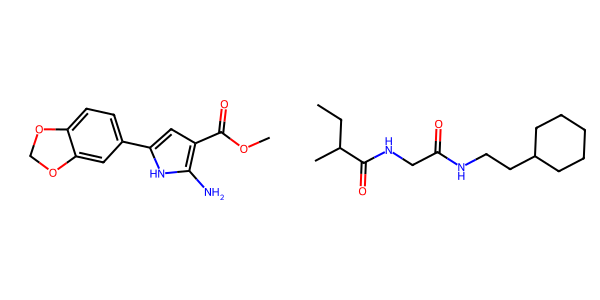

In [149]:
outputs = []
idx = 60
smi = df.SMILES.values[idx]
# smi = 'COc1ccc(C2CC(=O)Nc3nc(C)nn3C2)cc1'
outputs.append(smi)
for i in range(1):
    outputs.append(model.generate(num_samples=1, smiles=None))
print(smi)
print(outputs)
dm.to_image(outputs)

In [51]:
device = model.device

In [48]:
for i in val_dl:
    with_bos, targets, masks = i 
    last_hidden_state, emb, logvar, mu = model.encode(with_bos.to(model.device), mask=masks.to(model.device))
    z = model.reparameterize(mu, logvar)
    outputs = model.decode(z.to(model.device), with_bos.to(model.device), mask=masks.to(model.device))
    break

In [49]:
model.compute_loss(outputs.to(device), targets.to(device), logvar.to(device), mu.to(device))

(tensor(9580.8359, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(19.8293, device='cuda:0', grad_fn=<MulBackward0>))

In [50]:
with_bos[:,1:]

tensor([[ 4, 11, 10,  ...,  2,  2,  2],
        [ 4,  4,  6,  ...,  2,  2,  2],
        [ 4,  8,  4,  ...,  2,  2,  2],
        ...,
        [ 4, 11, 10,  ...,  2,  2,  2],
        [ 4,  4, 19,  ...,  2,  2,  2],
        [ 8,  7,  4,  ...,  2,  2,  2]])

In [28]:
e = model.embedding(with_bos.to(device))
e.shape

torch.Size([32, 44, 32])

In [38]:
e.shape

torch.Size([32, 44, 32])

In [37]:
e[:,1].shape

torch.Size([32, 32])